# Neural networks

In [1]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [2]:
df = pd.read_csv('data/laptop_train.csv')

In [3]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370


In [4]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   int64  
 1   product              1132 non-null   int64  
 2   typename             1132 non-null   int64  
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   int64  
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   int64  
 7   opsys                1132 non-null   int64  
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   int64  
 10  screentype           1132 non-null   int64  
 11  touchscreen          1132 non-null   int64  
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   int64  
 15  memory_2_storage_gb  1132 non-null   f

In [6]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [7]:
# en = LabelEncoder()
# for cols in catFeatures:
#     df[cols] = en.fit_transform(df[cols])
# print('Dataframe encoded by Label encoding dimension : ', df.shape)

In [9]:
# One hot encoding
#dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
#df = pd.concat([df[numericFeatures], dummLev, df[[target]]], axis=1)

#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [10]:
#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [11]:
features = df.columns.tolist()
features.remove(target)

In [12]:
df

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,7,111,3,14.0,52,4,47,5,1.54,3,2,0,2.3,500.0,1,0.0,3,6.907755
1128,0,77,3,15.6,57,8,86,5,2.40,3,2,0,2.5,256.0,3,1000.0,0,6.683361
1129,7,27,3,15.6,73,8,53,5,2.04,0,2,0,2.7,2000.0,1,0.0,3,6.444131
1130,7,324,3,15.6,10,6,29,5,2.04,3,2,0,2.9,1000.0,2,0.0,3,6.309900


In [13]:
#X=df.drop('log_price', axis = 1).values
#y=df['log_price'].values

# Neural network

In [13]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn import metrics

In [14]:
x = df.drop('log_price', axis=1)
y = df['log_price']

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(792, 17)
(170, 17)
(170, 17)


In [ ]:
sc=StandardScaler()

scaler = sc.fit(trainX)

trainX_scaled = scaler.transform(trainX)
valX_scaled = scaler.transform(valX)
testX_scaled = scaler.transform(testX)

In [ ]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'ANN_2FC_F64_64_epoch_120'

In [ ]:
input_shape = trainX.shape[1]

n_batch_size = 128

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 120


print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: 17
Batch Size: 128

Steps per Epoch: 6

Validation Steps: 1
Test Steps: 1

Number of Epochs: 120


In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                1152      
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 64)                4160      
                                                                 
 dense_135 (Dense)           (None, 1)                 65        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

In [ ]:
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [ ]:
history = model.fit(trainX_scaled,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX_scaled, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/120
6/6 [==============================] - 2s 173ms/step - loss: 41.6270 - mae: 6.4047 - val_loss: 31.6528 - val_mae: 5.5433
Epoch 2/120
6/6 [==============================] - 1s 142ms/step - loss: 23.9281 - mae: 4.7623 - val_loss: 17.7750 - val_mae: 3.9876
Epoch 3/120
6/6 [==============================] - 1s 144ms/step - loss: 12.4564 - mae: 3.2543 - val_loss: 8.6171 - val_mae: 2.5896
Epoch 4/120
6/6 [==============================] - 1s 141ms/step - loss: 5.6839 - mae: 1.9855 - val_loss: 5.2372 - val_mae: 1.8778
Epoch 5/120
6/6 [==============================] - 1s 142ms/step - loss: 4.0280 - mae: 1.6423 - val_loss: 3.7109 - val_mae: 1.5931
Epoch 6/120
6/6 [==============================] - 1s 145ms/step - loss: 2.8905 - mae: 1.3587 - val_loss: 2.7895 - val_mae: 1.3941
Epoch 7/120
6/6 [==============================] - 1s 200ms/step - loss: 2.2032 - mae: 1.1965 - val_loss: 2.1629 - val_mae: 1.2031
Epoch 8/120
6/6 [==============================] - 1s 142ms/step - loss: 1.783

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,mae,val_loss,val_mae
0,1,41.627048,6.404726,31.652792,5.543263
1,2,23.928120,4.762258,17.774973,3.987603
2,3,12.456367,3.254271,8.617093,2.589633
3,4,5.683879,1.985530,5.237187,1.877754
4,5,4.028008,1.642322,3.710943,1.593099


In [ ]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,mae,val_loss,val_mae
116,117,0.06077,0.199206,0.113738,0.239779


In [ ]:
pk.dump(scaler, open(checkpoint_no + '/' + 'scaler.pkl', 'wb'))

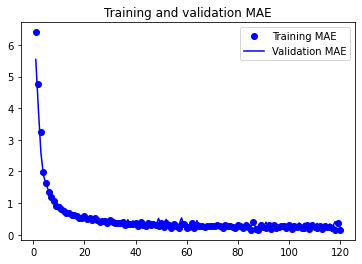

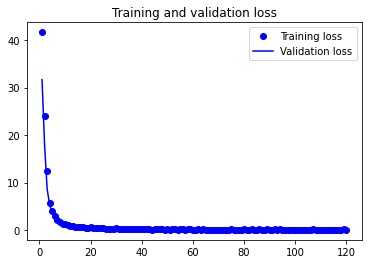

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## K-fold cross validation

In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


In [ ]:
k = 5
num_val_samples = len(trainX) // k

In [ ]:
all_scores = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    print('MAE: ' + str(val_mae))
    print('----------------------')

Processing Fold 0
MAE: 0.2929545044898987
----------------------
Processing Fold 1
MAE: 0.2667238116264343
----------------------
Processing Fold 2
MAE: 0.31392064690589905
----------------------
Processing Fold 3
MAE: 0.28865838050842285
----------------------
Processing Fold 4
MAE: 0.2778300642967224
----------------------


In [ ]:
for i, val in enumerate(all_scores):
    print('Fold ' + str(i) +': ' + 'MAE of', val)

Fold 0: MAE of 0.2929545044898987
Fold 1: MAE of 0.2667238116264343
Fold 2: MAE of 0.31392064690589905
Fold 3: MAE of 0.28865838050842285
Fold 4: MAE of 0.2778300642967224


In [ ]:
print('Mean MAE of all folds: ' + str(np.mean(all_scores)))

Mean MAE of all folds: 0.28801748156547546


In [ ]:
all_mae_histories = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold 0
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4


In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]

len(average_mae_history)

120

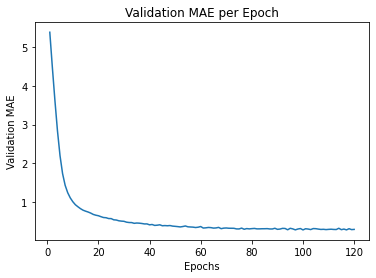

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
      '''
      Function for smoothing data points

      Args:
          points (float64): Array of floats to be smoothed, numpy array of floats

      Returns:
          Smoothed data points
      '''  
      smoothed_points = []
      for point in points:
        if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
        else:
          smoothed_points.append(point)
      return smoothed_points

In [ ]:
n_first_observations_to_exclude = 30

smooth_mae_history = smooth_curve(average_mae_history[n_first_observations_to_exclude:])

smooth_mae_history = pd.DataFrame(smooth_mae_history)
smooth_mae_history = smooth_mae_history.set_index(smooth_mae_history.index + n_first_observations_to_exclude)
smooth_mae_history.head()

,0
30,0.489379
31,0.488464
32,0.487497
33,0.484723
34,0.482996


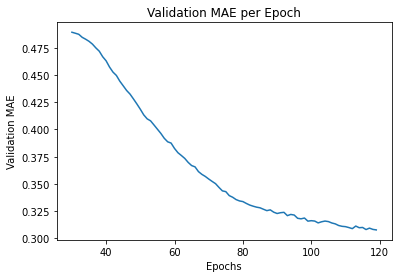

In [ ]:
plt.plot(smooth_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [ ]:
best_model = load_model(model_name_temp)

In [ ]:
test_loss, test_mae = best_model.evaluate(testX_scaled,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test MAE:', test_mae)

1/1 [==============================] - 0s 111ms/step - loss: 0.1071 - mae: 0.2567

Test MAE: 0.2566562294960022


In [ ]:
X = scaler.transform(df[features])

In [ ]:
pred = model.predict(X)

36/36 [==============================] - 0s 1ms/step


In [ ]:
df_Y = pd.DataFrame(df[target])
df_pred = pd.DataFrame(model.predict(X))

df_Y.reset_index(drop=True, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

df_results = pd.concat([df_Y, df_pred], axis=1)
df_results.columns = ['Actual', 'Predicted']

df_results

36/36 [==============================] - 0s 2ms/step


,Actual,Predicted
0,6.129050,6.168833
1,6.720220,6.827619
2,7.364547,7.180570
3,6.591674,6.507847
4,6.143370,5.954983
...,...,...
1127,6.907755,6.340419
1128,6.683361,6.708959
1129,6.444131,6.306248
1130,6.309900,6.183661


In [ ]:
metrics.r2_score(df[target], pred)

0.7776325845091294

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df[target], pred))
print('Mean Squared Error:', metrics.mean_squared_error(df[target], pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(df[target], pred, squared=False))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(df[target], pred))

Mean Absolute Error: 0.19128340971782043
Mean Squared Error: 0.08156991520304348
Root Mean Squared Error: 0.2856044733596508
Mean Absolute Percentage Error: 0.028279678888303985


## Random Search with KFold cross validation

In [126]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [127]:
df = pd.read_csv('data/laptop_train.csv')

In [128]:
from tensorflow import keras

def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, momentum = 0.9,  decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0, input_shape=1000, output_shape=1):
    
    opt = keras.optimizers.SGD(lr=lr, momentum=momentum)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = models.Sequential()
    
    # for the firt layer we need to specify the input dimensions
    first=True
    
    for i in range(nl1):
        if first:
            model.add(layers.Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(layers.Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(layers.Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer=opt, metrics=['mae'],)
    return model

In [129]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from keras.wrappers.scikit_learn import KerasRegressor

class SScaler(StandardScaler):
  def fit_transform(self, X, y=None):
    print(len(X))
    return super().fit_transform(X,y)

pipe = Pipeline([
    ('sc', StandardScaler()),
    ('kr', KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1))
])

<ipython-input-129-e6235ae88227>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('kr', KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1))


In [130]:
lr=[1e-2, 1e-3, 1e-4]
decay=[1e-6,1e-9,0]

# activation
activation=['relu', 'sigmoid']

# numbers of layers
nl1 = [0,1,2,3]
nl2 = [0,1,2,3]
nl3 = [0,1,2,3]

# neurons in each layer
nn1=[300,700,1400, 2100,]
nn2=[100,400,800]
nn3=[50,150,300]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.1, 0.05, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.1, 0.05, 0.01, 0.003, 0.001,0.0001]

# momentum
momentum = [0.1, 0.3, 0.5, 0.7, 0.9]

# dictionary summary
param_grid = dict(
                    kr__nl1=nl1, kr__nl2=nl2, kr__nl3=nl3, kr__nn1=nn1, kr__nn2=nn2, kr__nn3=nn3,
                    kr__act=activation, kr__l1=l1, kr__l2=l2, kr__lr=lr, kr__decay=decay, kr__dropout=dropout, kr__momentum=momentum,
                    kr__input_shape=[x.shape[1]],
                 )

In [131]:
from sklearn.model_selection import cross_val_score, KFold

grid = RandomizedSearchCV(estimator=pipe, cv=KFold(3), param_distributions=param_grid, 
                          verbose=20,  n_iter=1, n_jobs=1)

In [165]:
grid_result = grid.fit(x.to_numpy(), y)
grid.fit(x.to_numpy(), y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START kr__act=sigmoid, kr__decay=0, kr__dropout=0.2, kr__input_shape=17, kr__l1=0.01, kr__l2=0.001, kr__lr=0.001, kr__momentum=0.9, kr__nl1=3, kr__nl2=2, kr__nl3=0, kr__nn1=700, kr__nn2=800, kr__nn3=300


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 3s 47ms/step - loss: 698.8282 - mae: 2.4849
Epoch 2/100
24/24 [==============================] - 1s 56ms/step - loss: 646.1125 - mae: 0.7985
Epoch 3/100
24/24 [==============================] - 1s 55ms/step - loss: 596.2436 - mae: 0.5973
Epoch 4/100
24/24 [==============================] - 1s 55ms/step - loss: 548.2866 - mae: 0.5769
Epoch 5/100
24/24 [==============================] - 1s 57ms/step - loss: 502.3579 - mae: 0.5937
Epoch 6/100
24/24 [==============================] - 1s 52ms/step - loss: 458.3563 - mae: 0.5673
Epoch 7/100
24/24 [==============================] - 1s 46ms/step - loss: 416.4521 - mae: 0.5616
Epoch 8/100
24/24 [==============================] - 1s 52ms/step - loss: 376.5048 - mae: 0.5273
Epoch 9/100
24/24 [==============================] - 1s 55ms/step - loss: 338.6828 - mae: 0.5459
Epoch 10/100
24/24 [==============================] - 1s 50ms/step - loss: 302.8717 - mae: 0.5639
Epoch 11/100
24/24 [=========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 46ms/step - loss: 699.3306 - mae: 2.6449
Epoch 2/100
24/24 [==============================] - 1s 52ms/step - loss: 645.7068 - mae: 0.9043
Epoch 3/100
24/24 [==============================] - 1s 56ms/step - loss: 595.5365 - mae: 0.5807
Epoch 4/100
24/24 [==============================] - 1s 55ms/step - loss: 547.5343 - mae: 0.5510
Epoch 5/100
24/24 [==============================] - 1s 54ms/step - loss: 501.5860 - mae: 0.5560
Epoch 6/100
24/24 [==============================] - 1s 56ms/step - loss: 457.6349 - mae: 0.5444
Epoch 7/100
24/24 [==============================] - 1s 52ms/step - loss: 415.7336 - mae: 0.5507
Epoch 8/100
24/24 [==============================] - 1s 48ms/step - loss: 375.8358 - mae: 0.5361
Epoch 9/100
24/24 [==============================] - 2s 65ms/step - loss: 337.9756 - mae: 0.5373
Epoch 10/100
24/24 [==============================] - 2s 95ms/step - loss: 302.1795 - mae: 0.5666
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 57ms/step - loss: 697.8854 - mae: 2.4480
Epoch 2/100
24/24 [==============================] - 1s 49ms/step - loss: 645.6111 - mae: 0.9183
Epoch 3/100
24/24 [==============================] - 1s 45ms/step - loss: 595.4508 - mae: 0.5927
Epoch 4/100
24/24 [==============================] - 1s 48ms/step - loss: 547.4510 - mae: 0.5844
Epoch 5/100
24/24 [==============================] - 1s 54ms/step - loss: 501.4790 - mae: 0.5719
Epoch 6/100
24/24 [==============================] - 1s 52ms/step - loss: 457.5534 - mae: 0.5788
Epoch 7/100
24/24 [==============================] - 1s 56ms/step - loss: 415.6223 - mae: 0.5617
Epoch 8/100
24/24 [==============================] - 1s 57ms/step - loss: 375.7781 - mae: 0.5781
Epoch 9/100
24/24 [==============================] - 1s 50ms/step - loss: 337.9022 - mae: 0.5503
Epoch 10/100
24/24 [==============================] - 1s 46ms/step - loss: 302.0940 - mae: 0.5595
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


36/36 [==============================] - 3s 51ms/step - loss: 686.6722 - mae: 2.1813
Epoch 2/100
36/36 [==============================] - 2s 55ms/step - loss: 608.4281 - mae: 0.6109
Epoch 3/100
36/36 [==============================] - 2s 57ms/step - loss: 536.4796 - mae: 0.5850
Epoch 4/100
36/36 [==============================] - 2s 55ms/step - loss: 469.0023 - mae: 0.5558
Epoch 5/100
36/36 [==============================] - 2s 56ms/step - loss: 406.1006 - mae: 0.5414
Epoch 6/100
36/36 [==============================] - 2s 56ms/step - loss: 347.8023 - mae: 0.5480
Epoch 7/100
36/36 [==============================] - 2s 56ms/step - loss: 294.0536 - mae: 0.5420
Epoch 8/100
36/36 [==============================] - 2s 58ms/step - loss: 244.8837 - mae: 0.5476
Epoch 9/100
36/36 [==============================] - 2s 56ms/step - loss: 200.2544 - mae: 0.5461
Epoch 10/100
36/36 [==============================] - 2s 53ms/step - loss: 160.1707 - mae: 0.5539
Epoch 11/100
36/36 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 33ms/step - loss: 447.9688 - mae: 0.9295
Epoch 2/100
24/24 [==============================] - 1s 32ms/step - loss: 397.4748 - mae: 0.5716
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 351.9389 - mae: 0.5699
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 309.2393 - mae: 0.5666
Epoch 5/100
24/24 [==============================] - 1s 33ms/step - loss: 269.4387 - mae: 0.5881
Epoch 6/100
24/24 [==============================] - 1s 41ms/step - loss: 232.4786 - mae: 0.5776
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 198.3386 - mae: 0.5602
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 167.0524 - mae: 0.5582
Epoch 9/100
24/24 [==============================] - 1s 39ms/step - loss: 138.6360 - mae: 0.5587
Epoch 10/100
24/24 [==============================] - 1s 41ms/step - loss: 113.0108 - mae: 0.5675
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 38ms/step - loss: 446.6364 - mae: 0.8404
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 396.8882 - mae: 0.5576
Epoch 3/100
24/24 [==============================] - 1s 32ms/step - loss: 351.3785 - mae: 0.5706
Epoch 4/100
24/24 [==============================] - 1s 34ms/step - loss: 308.7083 - mae: 0.5701
Epoch 5/100
24/24 [==============================] - 1s 41ms/step - loss: 268.8892 - mae: 0.5567
Epoch 6/100
24/24 [==============================] - 1s 38ms/step - loss: 231.9332 - mae: 0.5482
Epoch 7/100
24/24 [==============================] - 1s 37ms/step - loss: 197.8469 - mae: 0.5496
Epoch 8/100
24/24 [==============================] - 1s 32ms/step - loss: 166.5973 - mae: 0.5613
Epoch 9/100
24/24 [==============================] - 1s 39ms/step - loss: 138.1603 - mae: 0.5535
Epoch 10/100
24/24 [==============================] - 1s 39ms/step - loss: 112.5252 - mae: 0.5290
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 3s 41ms/step - loss: 446.9306 - mae: 0.9057
Epoch 2/100
24/24 [==============================] - 1s 40ms/step - loss: 396.6334 - mae: 0.5582
Epoch 3/100
24/24 [==============================] - 1s 40ms/step - loss: 351.1497 - mae: 0.5685
Epoch 4/100
24/24 [==============================] - 1s 38ms/step - loss: 308.5439 - mae: 0.5726
Epoch 5/100
24/24 [==============================] - 1s 39ms/step - loss: 268.7505 - mae: 0.5560
Epoch 6/100
24/24 [==============================] - 1s 39ms/step - loss: 231.8841 - mae: 0.5787
Epoch 7/100
24/24 [==============================] - 1s 40ms/step - loss: 197.8209 - mae: 0.5608
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 166.6170 - mae: 0.5665
Epoch 9/100
24/24 [==============================] - 1s 35ms/step - loss: 138.2061 - mae: 0.5535
Epoch 10/100
24/24 [==============================] - 1s 38ms/step - loss: 112.6727 - mae: 0.5703
Epoch 11/100
24/24 [=========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


36/36 [==============================] - 2s 36ms/step - loss: 434.4590 - mae: 0.7932
Epoch 2/100
36/36 [==============================] - 1s 37ms/step - loss: 362.6921 - mae: 0.5902
Epoch 3/100
36/36 [==============================] - 1s 37ms/step - loss: 298.6281 - mae: 0.5663
Epoch 4/100
36/36 [==============================] - 1s 36ms/step - loss: 241.0412 - mae: 0.5578
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 189.9453 - mae: 0.5686
Epoch 6/100
36/36 [==============================] - 1s 37ms/step - loss: 145.2738 - mae: 0.5837
Epoch 7/100
36/36 [==============================] - 1s 36ms/step - loss: 106.9263 - mae: 0.5765
Epoch 8/100
36/36 [==============================] - 1s 36ms/step - loss: 74.9182 - mae: 0.5700
Epoch 9/100
36/36 [==============================] - 1s 37ms/step - loss: 49.2453 - mae: 0.5670
Epoch 10/100
36/36 [==============================] - 1s 37ms/step - loss: 29.8621 - mae: 0.5574
Epoch 11/100
36/36 [========================

KeyboardInterrupt: ignored

In [133]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -33.459644 using {'kr__nn3': 300, 'kr__nn2': 100, 'kr__nn1': 2100, 'kr__nl3': 1, 'kr__nl2': 1, 'kr__nl1': 0, 'kr__momentum': 0.3, 'kr__lr': 0.0001, 'kr__l2': 0.1, 'kr__l1': 0.01, 'kr__input_shape': 17, 'kr__dropout': 0, 'kr__decay': 1e-09, 'kr__act': 'relu'}
-33.459644 (0.174639) with: {'kr__nn3': 300, 'kr__nn2': 100, 'kr__nn1': 2100, 'kr__nl3': 1, 'kr__nl2': 1, 'kr__nl1': 0, 'kr__momentum': 0.3, 'kr__lr': 0.0001, 'kr__l2': 0.1, 'kr__l1': 0.01, 'kr__input_shape': 17, 'kr__dropout': 0, 'kr__decay': 1e-09, 'kr__act': 'relu'}


In [134]:
#kr__act=relu, kr__decay=1e-06, kr__dropout=0, kr__input_shape=17, kr__l1=0, kr__l2=0, kr__lr=0.001, kr__momentum=0.5, kr__nl1=3, kr__nl2=3, kr__nl3=1, kr__nn1=2100, kr__nn2=100, kr__nn3=300

In [135]:
grid_result.best_score_

-33.45964431762695

In [138]:
best_model = grid_result.best_estimator_

In [137]:
from sklearn.metrics import r2_score
test = pd.read_csv('data/laptop_test.csv')
test = test.dropna()

df_nn = test.copy()

neural_network_pred = best_model.predict(df_nn[features])
neural_network_r2 = r2_score(np.exp(neural_network_pred), np.exp(df_nn[target]))
print("Neural Network\nR2: {:.4f} %".format(neural_network_r2*100))

1/5 [=====>........................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


5/5 [==============================] - 0s 5ms/step
Neural Network
R2: 25.7491 %


In [109]:
np.exp(neural_network_pred)

array([1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525, 1634.4525,
       1634.4525, 1634.4525, 1634.4525, 1634.4525, 

In [110]:
np.exp(df_nn[target])

0      1672.0
1      1149.0
2       499.0
3       899.0
4      1244.0
        ...  
126    1099.0
127     649.0
128    1379.0
129     699.0
130    1271.0
Name: log_price, Length: 131, dtype: float64

## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [71]:
model_reloaded.save("models/neural_network.h5")

NameError: ignored

In [157]:
best_model

Pipeline(steps=[('sc', StandardScaler()),
                ('kr',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fbd152c8a60>)])

In [158]:
import pickle
with open('nn.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [164]:
best_model.save('saved_model.h5')

AttributeError: ignored